# Seismic clusters from a scattering network

These features were calculated on the `kebo` machine with  approximately ten years of continuous data (broadband and three-components). They used long-duration windows (typically half hour long) and twenty-ish components and clusters. The goal is to investigate the relationship with the geodetic data.

In [1]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np
import obspy
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

import figures
from scatterings import ScatteringDatabase

## Global parameters

In [2]:
NETWORK = "network_1"
POOLING = "max"
REDUCTION = "fastica_30"
CLUSTERING = "kmeans_30"

SUFFIX = f"{REDUCTION}_{CLUSTERING}"
DIRPATH_FIGURES = f"./paper/{POOLING}"
FILEPATH_DATABASE = "./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl"
FILEPATH_NETWORK = f"./model/{NETWORK}.pkl"
FILEPATH_SCATTERINGS = f"./out/{NETWORK}_{POOLING}.pkl"
FILEPATH_CLUSTERS = f"./out/{NETWORK}_{POOLING}_{SUFFIX}.pkl"
FILEPATH_CATALOG = "./data/catalogs/tremors_S1_husker.csv"

# Create the directory for the figures if it does not exist.
os.makedirs(DIRPATH_FIGURES, exist_ok=True)

# Print out file
print(f"Figures will be saved in {DIRPATH_FIGURES}")

Figures will be saved in ./paper/max


## Load previous runs and database

In [3]:
# Scattering database
scatterings = ScatteringDatabase(
    filepath_database=FILEPATH_DATABASE,
    filepath_scatterings=FILEPATH_SCATTERINGS,
    filepath_model=FILEPATH_NETWORK,
)

# Clusters
features = pickle.load(open(FILEPATH_CLUSTERS, "rb"))
print(f"Clusters loaded from {FILEPATH_CLUSTERS}")
features

Clusters loaded from ./out/network_1_max_fastica_30_kmeans_30.pkl


<xarray.Dataset>
Dimensions:   (time: 142324, channel: 3, f1: 16, f2: 11, feature: 30,
               cluster: 30)
Coordinates:
  * f1        (f1) float64 8.409 7.071 5.946 5.0 ... 1.051 0.8839 0.7433 0.625
  * f2        (f2) float64 5.0 2.5 1.25 0.625 ... 0.01953 0.009766 0.004883
    index     (time) int64 140 141 142 143 144 ... 147785 147786 147787 147788
  * time      (time) datetime64[ns] 2009-02-19T01:30:00 ... 2017-12-31T23:30:00
  * channel   (channel) <U3 'BHE' 'BHN' 'BHZ'
  * feature   (feature) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
  * cluster   (cluster) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Data variables:
    order_1   (time, channel, f1) float64 -1.075 -0.9542 ... -0.1543 -0.3065
    order_2   (time, channel, f1, f2) float64 -2.61 -1.69 ... -0.5729 -0.1364
    features  (feature, time) float64 0.6929 -2.644 -2.237 ... 1.043 0.03987
    clusters  (time, cluster) uint8 0 0 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    n_samples:           36001
    reduction:           FastICA(n_components=30, random_state=42)
    explained_variance:  0.9263424553110732
    clustering:          KMeans(n_clusters=30, random_state=42)

## Load earthquake catalog

<AxesSubplot: xlabel='lon', ylabel='lat'>

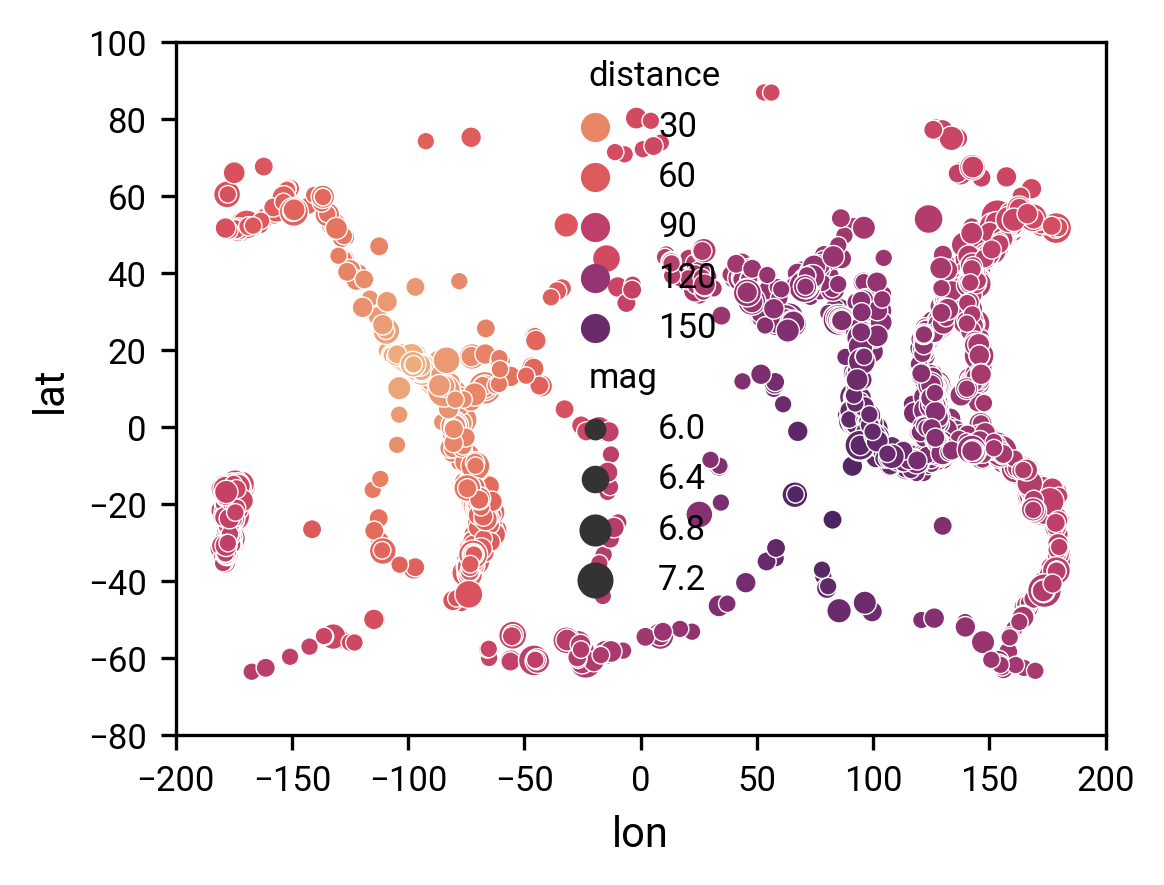

In [4]:
# Load catalog
FILEPATH_CATALOG = "./data/catalogs/isc_m6_global.csv"
STATION_LAT_LON = 18.2805, -100.3437
SPEED = 3.5 

catalog = pd.read_csv(
    FILEPATH_CATALOG, 
    usecols=range(12),
    skiprows=21,
    sep=",",
)

# Lowercase column names
catalog.columns = [col.lower() for col in catalog.columns]
catalog.columns = [col.strip() for col in catalog.columns]

# Print
# catalog = catalog[catalog.mag >= 6.5]
catalog = catalog.dropna()

# Convert to datetime
catalog = catalog.set_index(pd.to_datetime(catalog["date"]) + pd.to_timedelta(catalog["time"]))

# Correction of travel time based on epicentral distance
distance = obspy.geodetics.base.locations2degrees(catalog.lat, catalog.lon, *STATION_LAT_LON)
catalog["distance"] = distance
catalog["time"] = catalog.index + pd.to_timedelta(catalog["distance"] * 111.19 / SPEED, unit="s")

# Drop unnecessary columns
catalog = catalog[["time", "lat", "lon", "depth", "mag", "distance"]]

# Preview
sns.scatterplot(x="lon", y="lat", data=catalog, size="mag", hue="distance", palette="flare")

## Event distribution per cluster

In [5]:
# Observe in which cluster each earthquake falls
catalog["cluster"] = 0

def get_cluster(row):
    return features.sel(time=row.time, method="ffill").clusters.argmax().values.astype(int)

# Apply
catalog["cluster"] = catalog.apply(get_cluster, axis=1)

<AxesSubplot: xlabel='lon', ylabel='lat'>

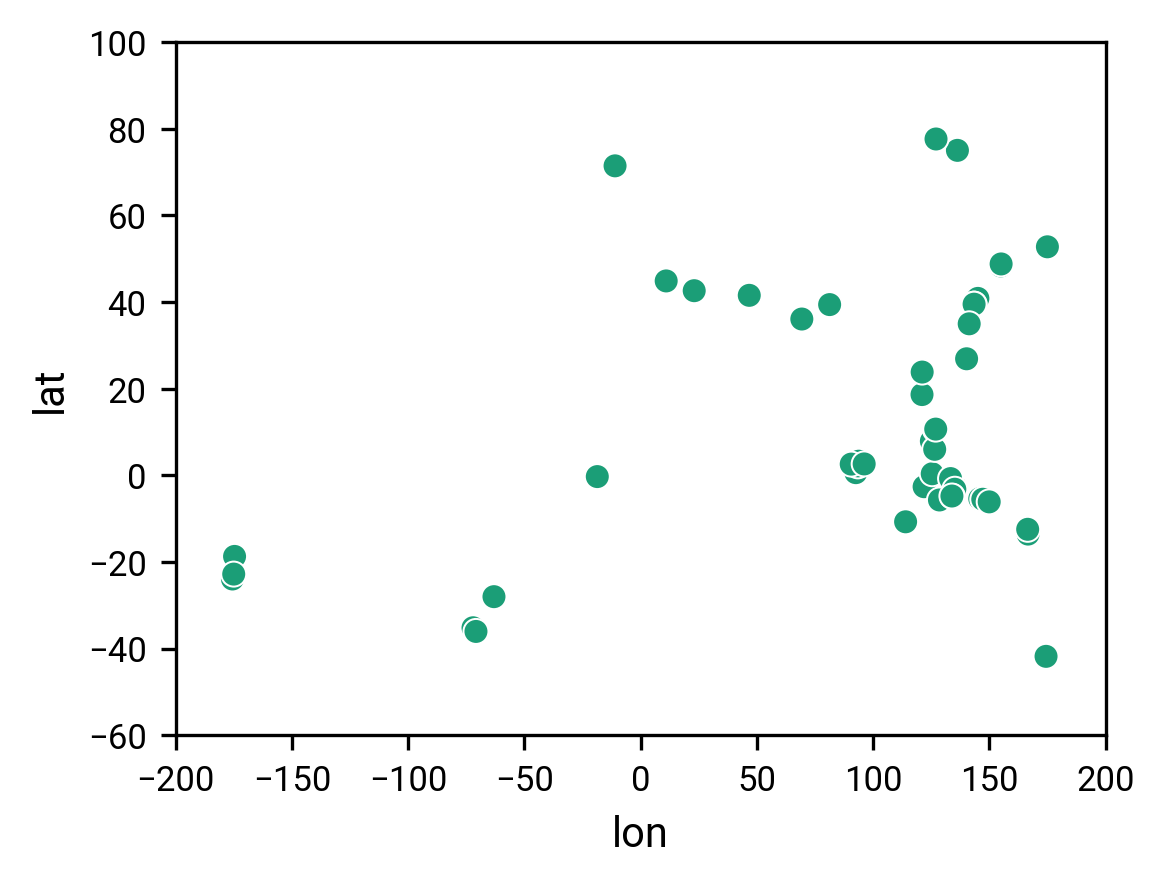

In [6]:
# Preview
catalog.cluster = catalog.cluster.astype(int)
sns.scatterplot(x="lon", y="lat", data=catalog[catalog.cluster == 14], hue="cluster", palette="Dark2", legend=False)

## Get distribution of events per clusters

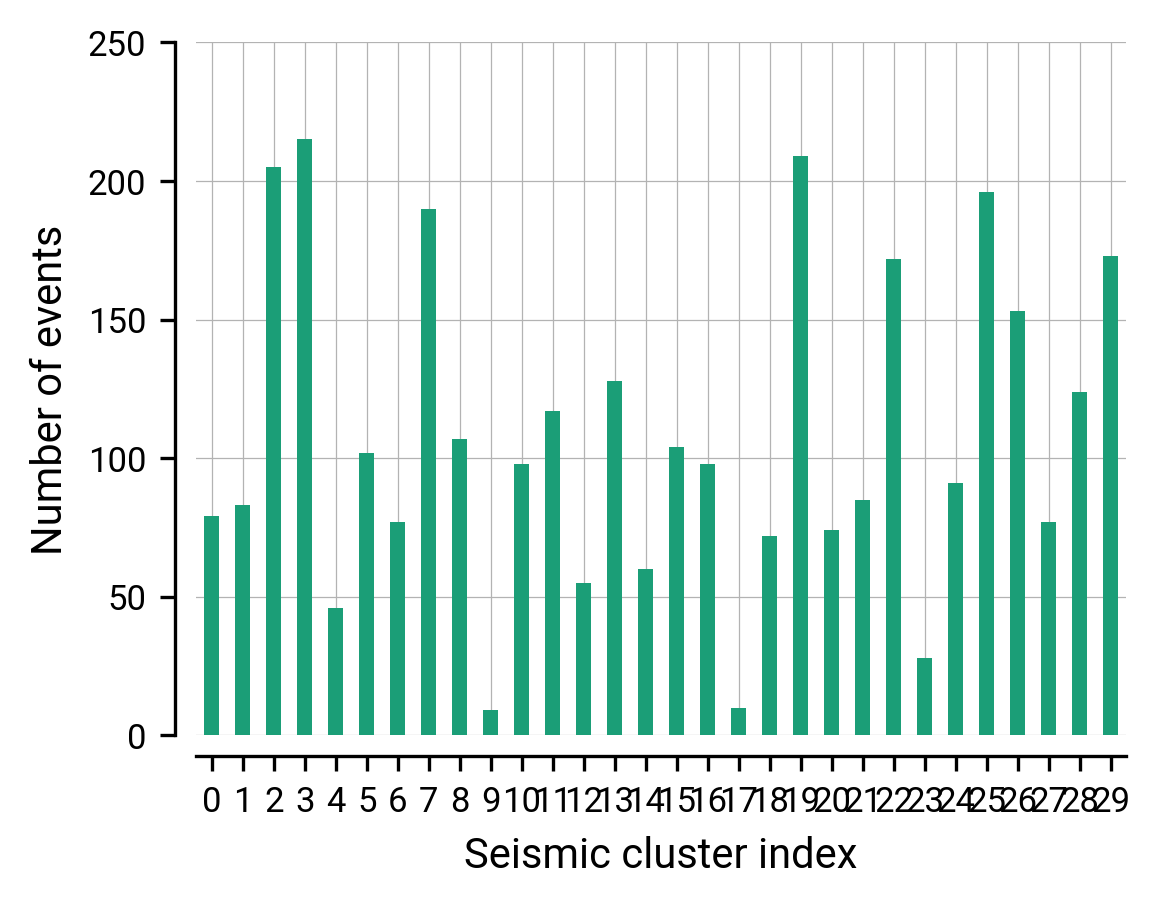

In [7]:
# Set palette
sns.set_palette("Dark2")

# Figure
fig, ax = plt.subplots()

# Show number of earthquakes per cluster
catalog.cluster.value_counts().sort_index().plot(kind="bar", ax=ax)

# Labels
sns.despine(offset=5)
ax.set_xlabel("Seismic cluster index")
ax.set_ylabel("Number of events")
ax.grid(True)

## Magnitude distribution per cluster

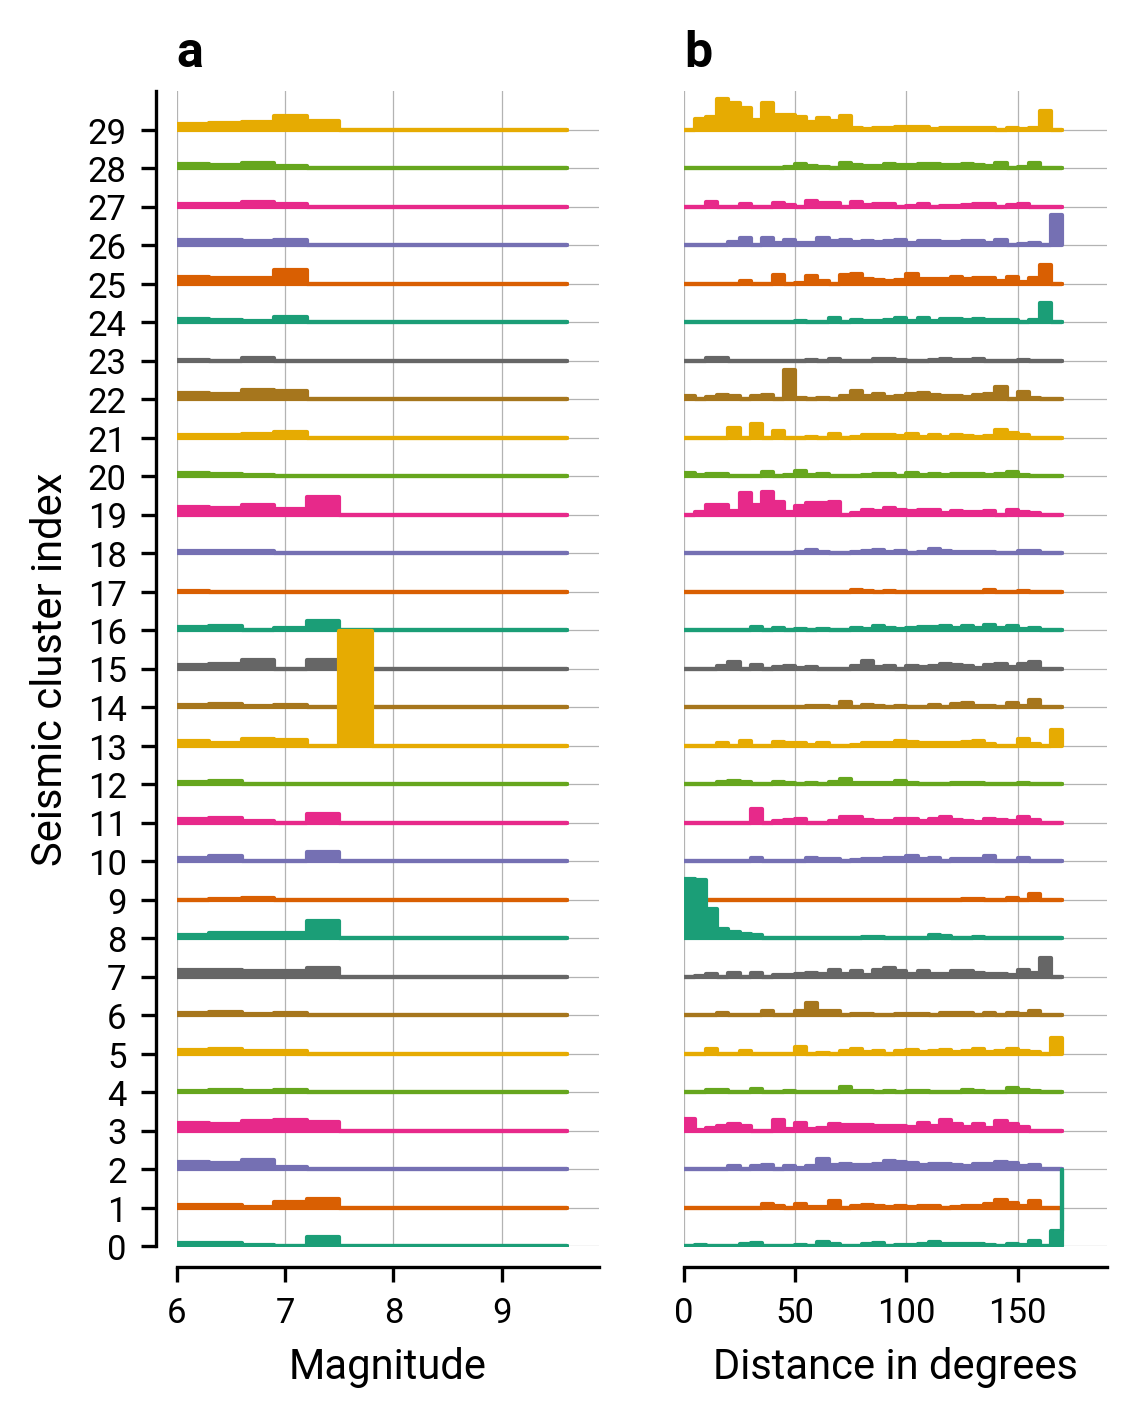

In [8]:
# Get mag KDE for the entire catalog
bins = np.arange(6, 10, 0.3)
data = catalog["mag"]
# kde = gaussian_kde(data, bw_method="silverman")
h, _ = np.histogram(data, bins=bins)
# distribution_mag = kde.evaluate(bins)

# Get distance KDE for the entire catalog
bins_dist = np.arange(0, 180, 5)
data = catalog["distance"]
# kde = gaussian_kde(data)
# distribution_dist = kde.evaluate(bins_dist)
h_d, _ = np.histogram(data, bins=bins_dist)

# Show magnitude distribution_mag per cluster
fig, ax = plt.subplots(1, 2, figsize=(4, 5), sharey=True)

# Loop over clusters
for cluster in catalog.cluster.unique():

    # Get data
    data = catalog[catalog.cluster == cluster]
    
    # Magnitude
    # kde = gaussian_kde(data["mag"])
    # cluster_distribution_mag = kde.evaluate(bins)
    # cluster_distribution_mag /= distribution_mag + 1e-3
    # cluster_distribution_mag /= 2
    h_cluster, _ = np.histogram(data["mag"], bins=bins)
    cluster_distribution_mag = h_cluster / (h + 1e-2)

    # Distance
    # kde = gaussian_kde(data["distance"])
    # cluster_distribution_dist = kde.evaluate(bins_dist)
    # cluster_distribution_dist /= distribution_dist + 1e-3
    # cluster_distribution_dist /= 4
    h_cluster, _ = np.histogram(data["distance"], bins=bins_dist)
    cluster_distribution_dist = h_cluster / (h_d + 1e-2)

    # Plot
    ax[0].fill_between(
        bins[:-1],
        cluster,
        cluster_distribution_mag * 3 + cluster,
        color=f"C{cluster}",
        zorder=features.attrs["clustering"].n_clusters - cluster,
        step="post",
    )

    # Plot
    ax[1].fill_between(
        bins_dist[:-1],
        cluster,
        cluster_distribution_dist * 2 + cluster,
        color=f"C{cluster}",
        zorder=features.attrs["clustering"].n_clusters - cluster,
        step="post",
    )


# Labels
ax[0].set_xlabel("Magnitude")
ax[0].set_ylabel("Seismic cluster index")
ax[0].set_xlim(bins.min(), bins.max())
ax[0].set_ylim(0, features.attrs["clustering"].n_clusters)
ax[0].set_yticks(features.cluster)
ax[0].grid(True)
ax[0].set_title("a", loc="left")
sns.despine(ax=ax[0], offset=5)

ax[1].set_xlabel("Distance in degrees")
ax[1].grid(True)
ax[1].set_xlim(bins_dist.min(), 190)
ax[1].tick_params(axis="y", labelleft=False, left=False)
ax[1].set_title("b", loc="left")
sns.despine(ax=ax[1], offset=5, left=True)


## Regional large earthquakes

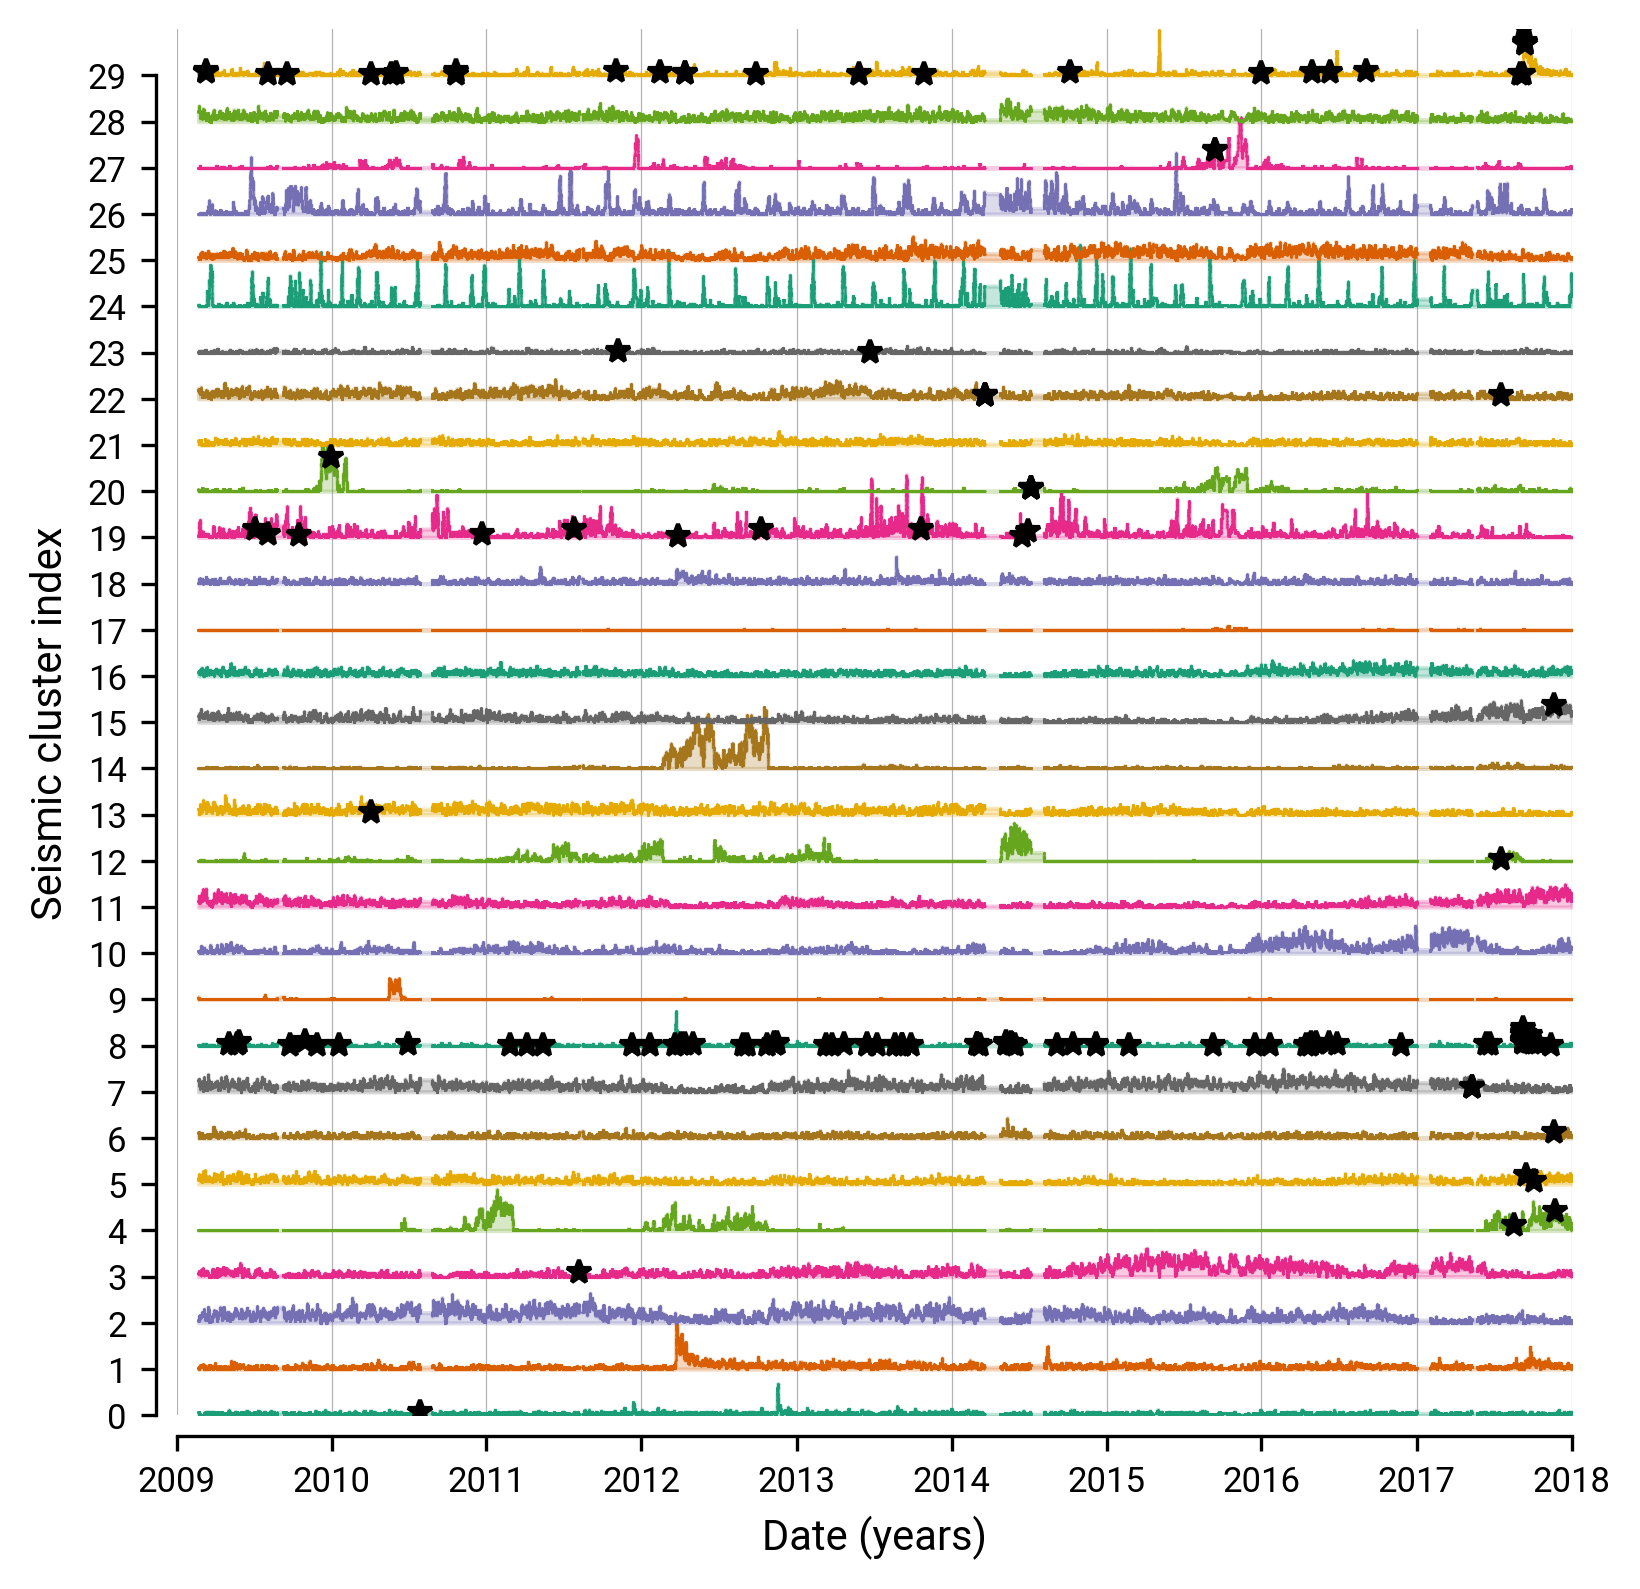

In [9]:
SMOOTHING_SAMPLES = 100

# Smooth out
clusters_smooth = features.clusters.rolling(time=SMOOTHING_SAMPLES, center=False).mean().dropna("time")

sns.set_palette("Dark2")

# Create figure
fig, ax = plt.subplots(1, figsize=(6, 6), dpi=300)

# Plot cluster detection rates
for i in range(features.attrs["clustering"].n_clusters):
    rate = clusters_smooth.isel(cluster=i) * 2 + i
    rate.plot(rasterized=True, ax=ax, marker=".", linestyle="none", ms=1, mew=0)
    ax.fill_between(rate.time, i, rate.values, color=f"C{i}", alpha=0.25, rasterized=True)
    

# Mark earthquakes
for i, row in catalog.iterrows():
 
    if row["time"] < clusters_smooth.time.min() or row["time"] > clusters_smooth.time.max():
        continue
    
    if row["mag"] < 6 or row["distance"] > 20:
        continue

    feature = features.sel(time=row.time, method="ffill")
    time = feature.time.values
    cluster = feature.clusters.argmax("cluster").values
    rate = clusters_smooth.isel(cluster=cluster).sel(time=time) * 2 + cluster
    
    ax.plot(rate.time, rate.values, "*k")

# Labels
ax.set_title("")
ax.set_yticks(features.cluster)
ax.set_ylim(0, features.attrs["clustering"].n_clusters)
ax.set_ylabel("Seismic cluster index")
ax.set_xlabel("Date (years)")
ax.set_xlim(pd.to_datetime("2009-01"), pd.to_datetime("2018-01"))
ax.grid(True, axis="x")

# Seaborn style
sns.despine(ax=ax, offset=5, trim=True)